In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns',150)
plt.style.use('bmh')
%matplotlib inline

In [2]:
data = pd.read_csv('responses.csv')

In [3]:
data_num = data.select_dtypes(include='number')

In [4]:
data_cat = data.select_dtypes(include='object')

In [5]:
data_of_interest = data[["Changing the past", "Happiness in life", "Religion", "Science and technology", ]]

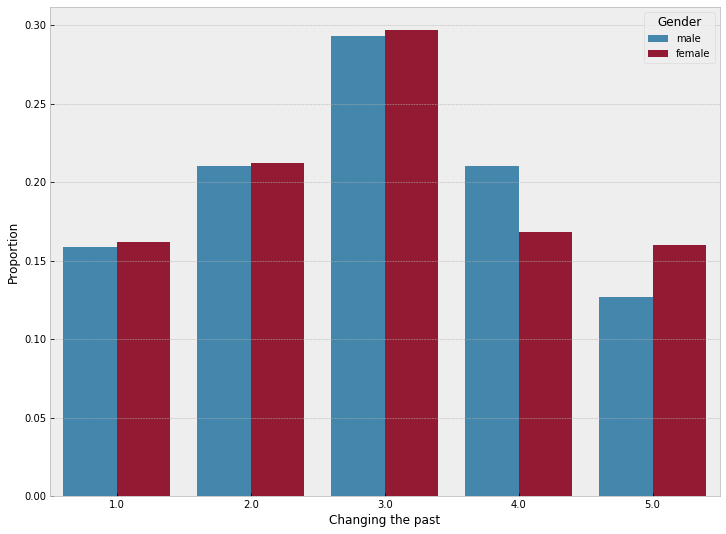

In [6]:
y, hue = "Proportion", "Gender"
hue_order = ["male", "female"]
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

x="Changing the past"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, hue_order=hue_order))

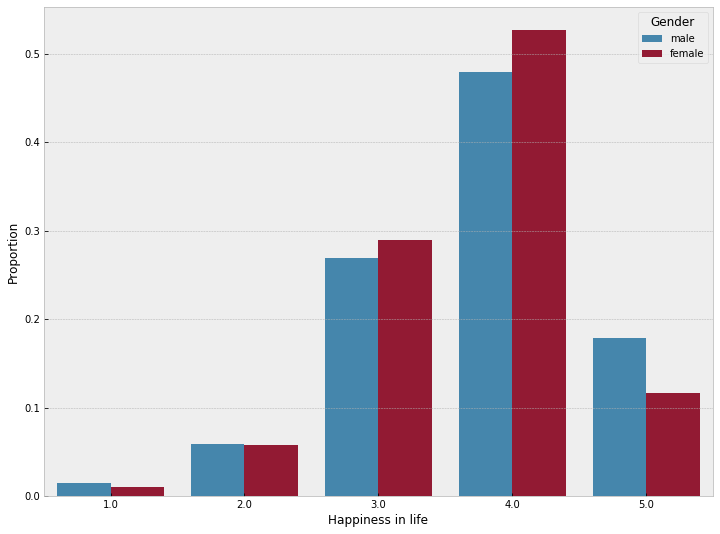

In [7]:
x="Happiness in life"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, hue_order=hue_order))

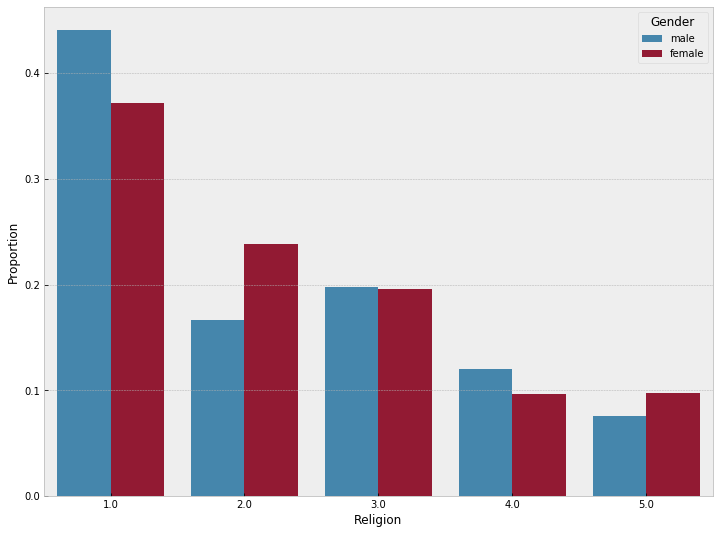

In [8]:
x="Religion"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, hue_order=hue_order))

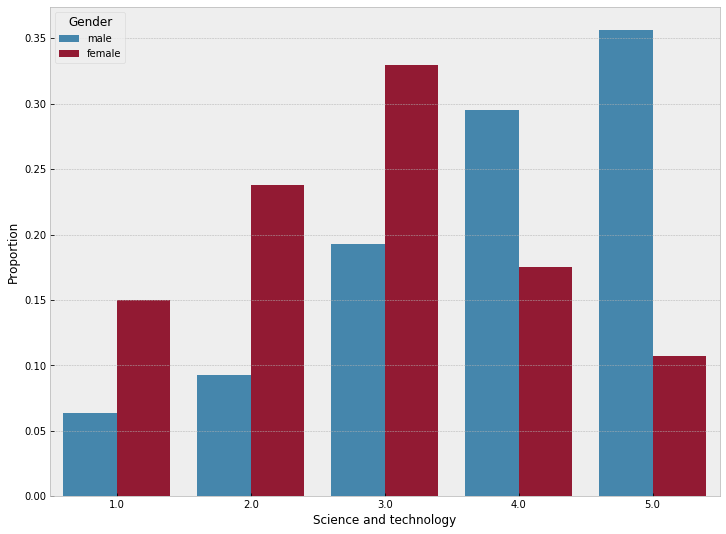

In [9]:
x="Science and technology"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, hue_order=hue_order))

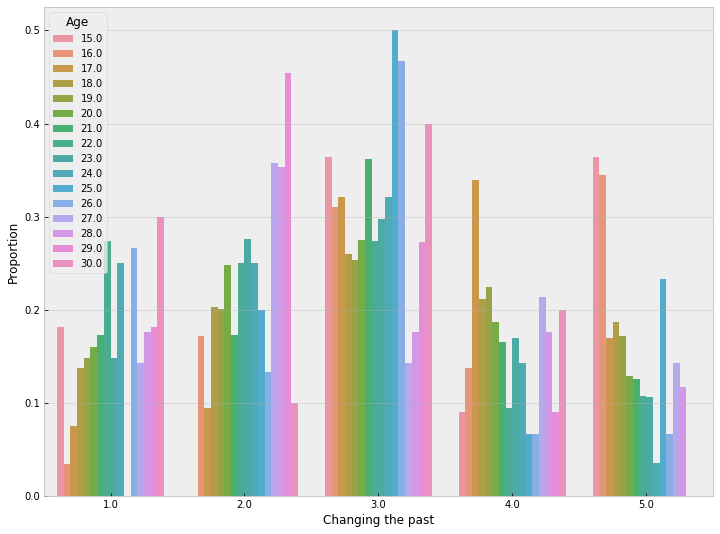

In [10]:
y, hue = "Proportion", "Age"
x="Changing the past"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

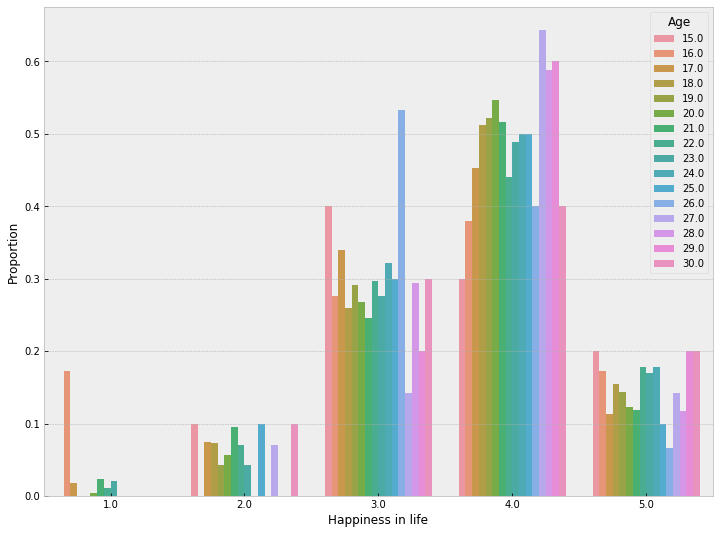

In [11]:
y, hue = "Proportion", "Age"
x="Happiness in life"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

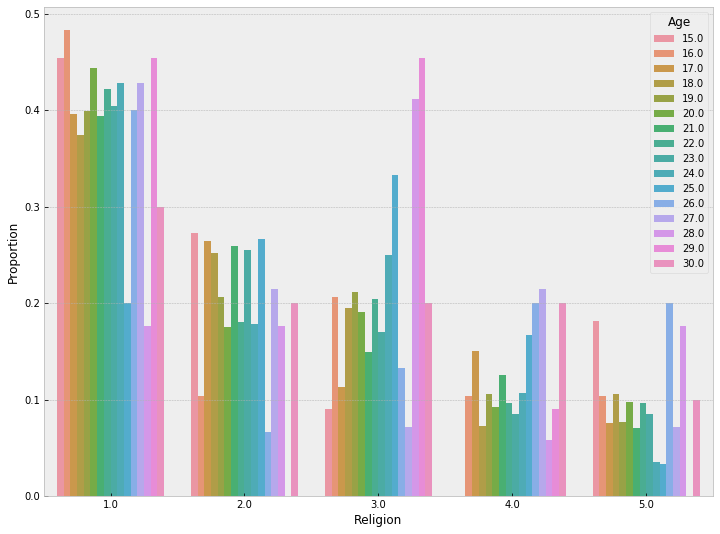

In [12]:
y, hue = "Proportion", "Age"
x="Religion"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

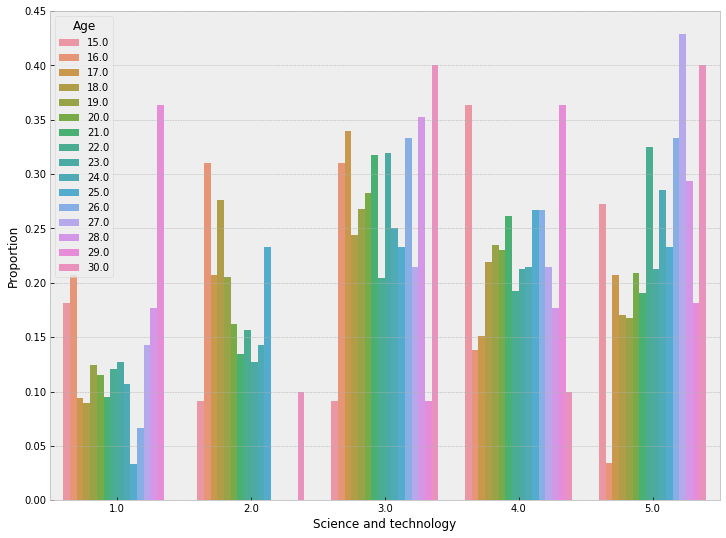

In [13]:
y, hue = "Proportion", "Age"
x="Science and technology"
(data[x].groupby(data[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

# Machine Learning

## Prepare Data

## Data Cleansing

To begin with, we check for multicollinearities. A fair approach to try and eliminate some multicollinearities is to remove highly correlated variables from the data (for example above |0.5|). 

In [14]:
all_cat_dummies=pd.get_dummies(data_cat)
all_data = data_num.join(all_cat_dummies)

corrs = all_data.corr()

non_dupl_corrs = (corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

display(non_dupl_corrs[abs(non_dupl_corrs)>0.5])

cols_to_drop = non_dupl_corrs[abs(non_dupl_corrs)>0.5].reset_index()['level_1']
cols_to_drop

Biology                                Medicine                                  0.715551
Height                                 Weight                                    0.697696
Biology                                Chemistry                                 0.689859
Height                                 Gender_male                               0.684602
Fantasy/Fairy tales                    Animated                                  0.674675
Shopping                               Shopping centres                          0.651585
Weight                                 Gender_male                               0.642649
Chemistry                              Medicine                                  0.626713
Village - town_village                 House - block of flats_house/bungalow     0.601867
Mathematics                            Physics                                   0.595992
Classical music                        Opera                                     0.595905
Village - 

0                                   Medicine
1                                     Weight
2                                  Chemistry
3                                Gender_male
4                                   Animated
5                           Shopping centres
6                                Gender_male
7                                   Medicine
8      House - block of flats_house/bungalow
9                                    Physics
10                                     Opera
11     House - block of flats_block of flats
12                                      Rats
13                             Gender_female
14                  Education_masters degree
15                                      Punk
16                                   Theatre
17                         Metal or Hardrock
18                         Spending on looks
19                                      Punk
20                                       God
21                           Public speaking
22        

Now we have to remove all dummy columns from cols_to_drop if they got into the list just because of having a |0.5|+ corr value with another dummy from the same category. This is the case for all of the variables from index 24 on, except for Gender_male and Gender_female. These two, however, are listed further up as well, so they will still stay on the list.
Interestingly enough, the models will now have "Life struggles" and "Height" standing for themselves as well as for "Gender" and "Weight".

In [15]:
cols_to_drop.to_frame()
cols_to_drop=cols_to_drop.drop(cols_to_drop.index[24:42])
cols_to_drop

0                                  Medicine
1                                    Weight
2                                 Chemistry
3                               Gender_male
4                                  Animated
5                          Shopping centres
6                               Gender_male
7                                  Medicine
8     House - block of flats_house/bungalow
9                                   Physics
10                                    Opera
11    House - block of flats_block of flats
12                                     Rats
13                            Gender_female
14                 Education_masters degree
15                                     Punk
16                                  Theatre
17                        Metal or Hardrock
18                        Spending on looks
19                                     Punk
20                                      God
21                          Public speaking
22                              

In [18]:
ml_data = all_data.dropna(subset=["Happiness in life"])
ml_data = ml_data.drop(cols_to_drop, axis=1)
ml_data.shape

(1006, 152)

##  Data imputation
For the imputation, we will use the median of all variables. This way we wont end up with rounding issues.

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [21]:
X = ml_data
median_values = X.median(axis=0)
X = X.apply(lambda x: x.fillna(x.median()),axis=0)
X.count(axis='columns')
# -> no more NAs, all rows with 152 actual values

Y = ml_data["Happiness in life"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=100)

### Oversampling

As we have seen in the EDA section in our R Script, the "Happiness in life" class is highly imbalanced. This is a problem for a lot of machine learning methods. To try and solve this, we will oversample the minority classes with SMOTE (Synthetic Minority Over-sampling Technique).

In [22]:
x_train.shape, y_train.shape

smote = SMOTE('auto')

x_sm, y_sm = smote.fit_sample(x_train, y_train)
print("Before SMOTE: ", x_train.shape, y_train.shape, "\nAfter SMOTE: ", x_sm.shape, y_sm.shape)

# see https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

Before SMOTE:  (704, 152) (704,) 
After SMOTE:  (1745, 152) (1745,)


## Model implementation

Here we will standardtize the data, tune the parametes and fit the Random Forest. Then we will predict and evaluate on the test set.

In [23]:
# standardization
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_sm = scaler.transform(x_sm)

In [25]:
# Random Forest implementation

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_sm, y_sm)

print(rf_random.best_params_)

best_random = rf_random.best_estimator_

y_pred=best_random.predict(x_test)

#code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}


In [26]:
# evaluation 3

print('Average accuracy score on test set: ', accuracy_score(y_test, y_pred))
print('Average f1 score on test set: ', f1_score(y_test, y_pred, average="macro"))
print('Average precision score on test set: ', precision_score(y_test, y_pred, average="macro"))
print('Average recall score on test set: ', recall_score(y_test, y_pred, average="macro")) 

Average accuracy score on test set:  0.9238410596026491
Average f1 score on test set:  0.8040378714491199
Average precision score on test set:  0.9371340078463761
Average recall score on test set:  0.7484652202573729


This model definitely  performed way better than the models I have (barely) managed to train in R-Studio. Experience in a programming language does help, I guess. I will go into detail in the Data Story. There I will also discuss possible improvements.